15012773                                                                                        

## Overview
For the first practical we were tasked with building a regression model to predict the Heating and Cool Load. We were provided with a dataset that was generated by the software Ecotect. We had to read in the read, clean and process data then create a regression model to predict output based on a set of inputs and evaluate its performance.

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates
from pandas.plotting import parallel_coordinates
from scipy import stats
from scipy.stats import spearmanr
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

warnings.filterwarnings("ignore")
%matplotlib inline


# Section 1 - Loading and Cleaning the data

## Reading in the dataset

The first step was to read in the data set that was in CSV format. Because the feature column names were labelled x1 to x8, and the outputs were labelled y1 and y2. The first step was to re-name the columns into something more helpful. In order to read in the dataset, I opted to use the pandas library. After the dataset is read all the rows are shuffled in an attempt to reduce variance and making sure that models remain general and prevent overfitting. This could be a problem in this particular dataset because all the data in the CSV file is sorted, i.e. all the instances of "Overall Height = 3.5" appear before all the instances of "Overall Height = 7"

In [2]:
# Defining all the features which will be used to index the dataframe 
feature_cols_basic = ['Relative Compactness', 'Surface Area', 'Wall Area',
                      'Roof Area', 'Overall Height', 'Orientation',
                      'Glazing area', 'Glazing area distribution']
feature_cols_extended = []
subset_feature_cols = []
target_cols = ['Heating Load', 'Cooling Load']


In [3]:
# The path of the data frame
notebook_path = os.path.abspath('visualizations.ipynb')
csv_path = os.path.join(os.path.dirname(notebook_path), './data/ENB2012_data.csv')


Bellow you can see the first 5 rows of the pandas data frame which represents the CSV file, as you can see the rows have been shuffled and the column names have been successful changed.



In [4]:
# Define a StandardScaler object which is used later to scale the data 
ss = StandardScaler()
# Rename the columns to the more meningful names
df = pd.read_csv(csv_path)
columns = {
    'X1': 'Relative Compactness',
    'X2': 'Surface Area',
    'X3': 'Wall Area',
    'X4': 'Roof Area',
    'X5': 'Overall Height',
    'X6': 'Orientation',
    'X7': 'Glazing area',
    'X8': 'Glazing area distribution',
    'Y1': 'Heating Load',
    'Y2': 'Cooling Load',
}
df.rename(index=str, columns=columns, inplace=True)
# Shuffle the data set to avoid ordered columns 
df = shuffle(df)
df.head()


,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing area,Glazing area distribution,Heating Load,Cooling Load
681,0.86,588.0,294.0,147.0,7.0,3,0.40,4,31.66,36.20
489,0.86,588.0,294.0,147.0,7.0,3,0.25,5,29.09,29.43
40,0.64,784.0,343.0,220.5,3.5,2,0.00,0,10.85,16.78
371,0.69,735.0,294.0,220.5,3.5,5,0.25,2,12.95,15.99
360,0.74,686.0,245.0,220.5,3.5,2,0.25,2,12.35,14.73


## Investigating the Dataset


In order to gain a better understanding of the dataset I decided use the pandas describe function to show the various attributes of the data. As can be seen by the result, each of the feature columns can take on very different values, for example the max value the feature "Relative Compactness" can take on is 0.980000, whereas the max value "Surface Area" can take on is 808.50000, which suggests all the features need to be normalised and scaled. Another interesting observation is how similar the target features "Heating Load" and "Cooling Load" are. Finally, I decided to check how many values each feature can take on. As it can be shown, all the features are categorical, and the output variables are continuous.



In [5]:
df.describe()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing area,Glazing area distribution,Heating Load,Cooling Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [6]:
# Count the number of distinct values for each feature 
df_counts = pd.DataFrame(pd.Series([len(np.unique(df[col].values)) for col in df]))
df_counts.columns = ['Number of possible values']
# Map the column names back to the originals 
df_counts.rename(dict(zip([x for x in range(len(df.columns.values))],
                          df.columns.values)), axis='index', inplace=True)
df_counts


,Number of possible values
Relative Compactness,12
Surface Area,12
Wall Area,7
Roof Area,4
Overall Height,2
Orientation,4
Glazing area,4
Glazing area distribution,6
Heating Load,586
Cooling Load,636


### Cleaning Data

Code Source : https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

In order to clean the data, I first remove all rows which contains a Nan value, next I remove all rows which contain an outlier. To this the absolute Z-score of each value in the in each column is calculated relative to the column mean and standard deviation. The reason the absolute value is calculated is because the direction does not matter, only if it is below the threshold. The "all(axis=1)" ensures that for each row, all column satisfy the constraint. Finally, result of this condition is used to index the data frame, thus meaning all rows which contain an out lier are dropped. However after both cleaning actions no rows are dropped.[1]

In [7]:
df.dropna(inplace=True)
# Remove all rows which have a feature whose p value is less than 3
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
print(len(df))

768


# Section 2 - Analysing and Visualising the data

## Visualisations -  Probability Density Using histograms

The first thing I decided to visualise was the probability densities this would shed light on what, if any features follows a Gaussian (normal) distribution. However, as it can be seen the data is non-Gaussian. Another observation is that even though the each of the features are categorical, the number of samples per category is non-uniform. For example, the minimum number of concourses of "Overall Height = 1" is 50, whereas there the the number of samples where "Overall Height" ≥ 1 is 140.

In order to build the plots I used the hist function which builds a histogram of the DataFrame’s. This function calls matplotlib.pyplot.hist(), on each series in the DataFrame, resulting in one histogram per column.[2]



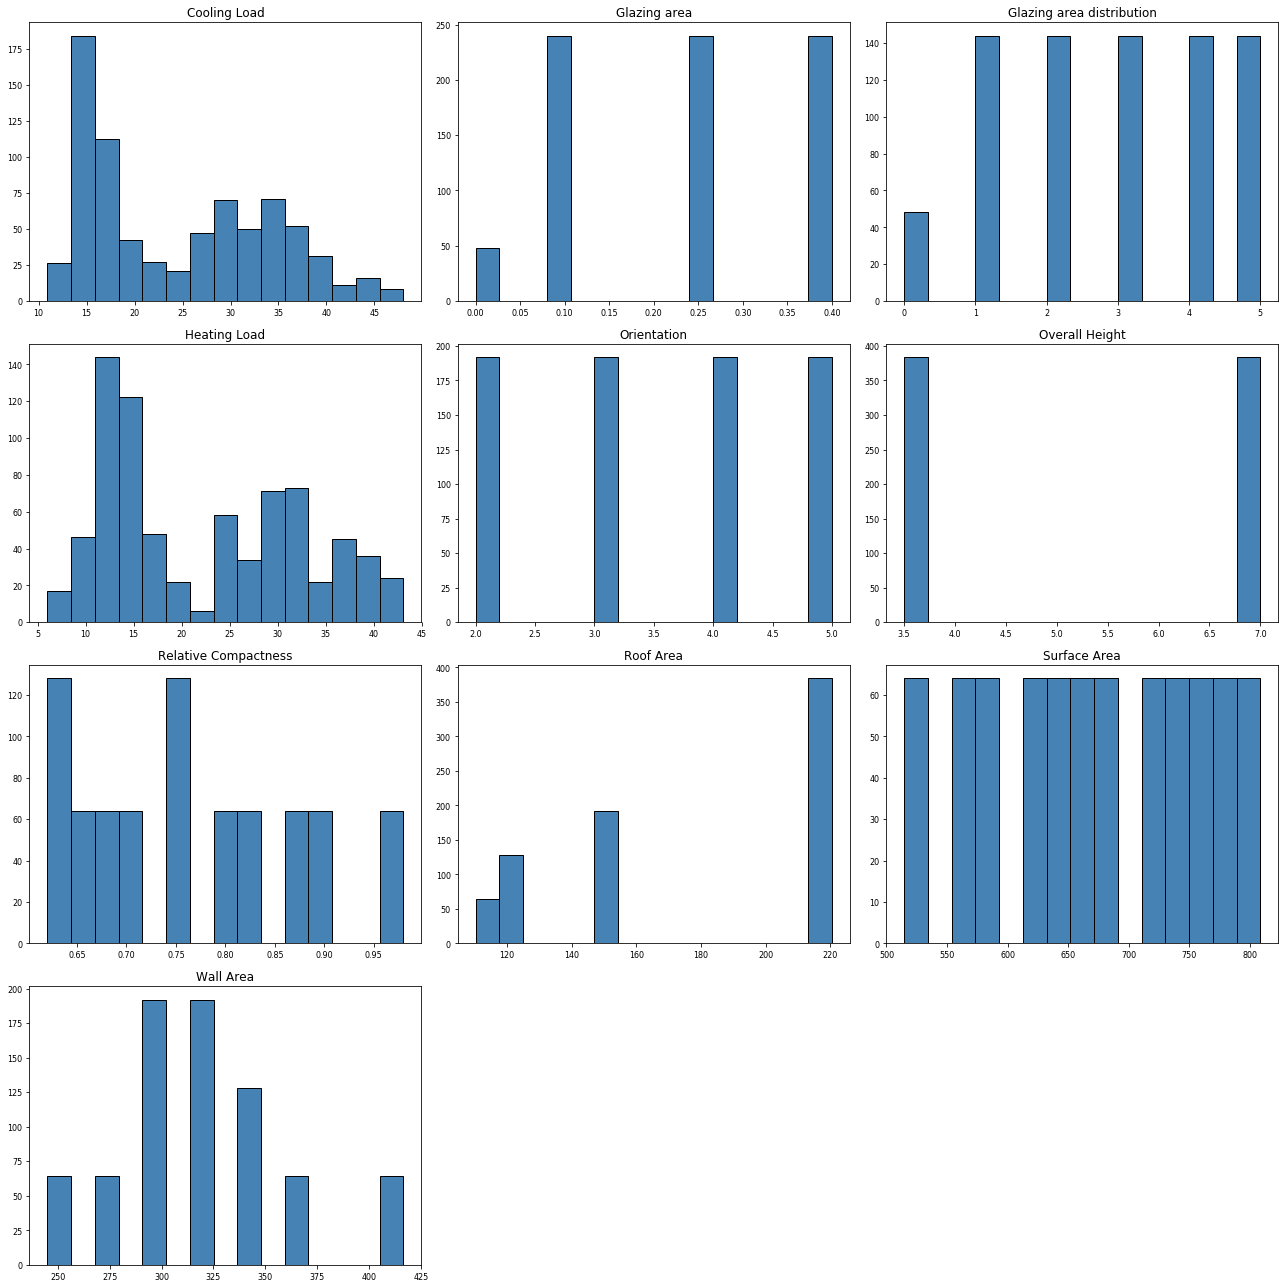

In [8]:
fig = plt.figure(figsize=(15, 15))
ax = fig.gca()
# Plot the histagrams of the data set
df.hist(ax=ax, bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
        xlabelsize=8, ylabelsize=8, grid=False)

plt.tight_layout(rect=(0, 0, 1.2, 1.2))
plt.show()



## Visualisations - Relationship Between Each Feature and Each Target Using Scatter Plot


Next I decided to visualise is how each input feature is related with each of the two output variables. In order to do this I used the seaborn library which has a catplot function that can create swarm plots. This allows us to gain a better understanding of how each variable is correlated with the output. For example, when the feature "Overall Height" equals 3.5, both the heating and cooling load appear to be lower, and when "Overall Height" equals 7, both the heating and cooling load appear to be higher.

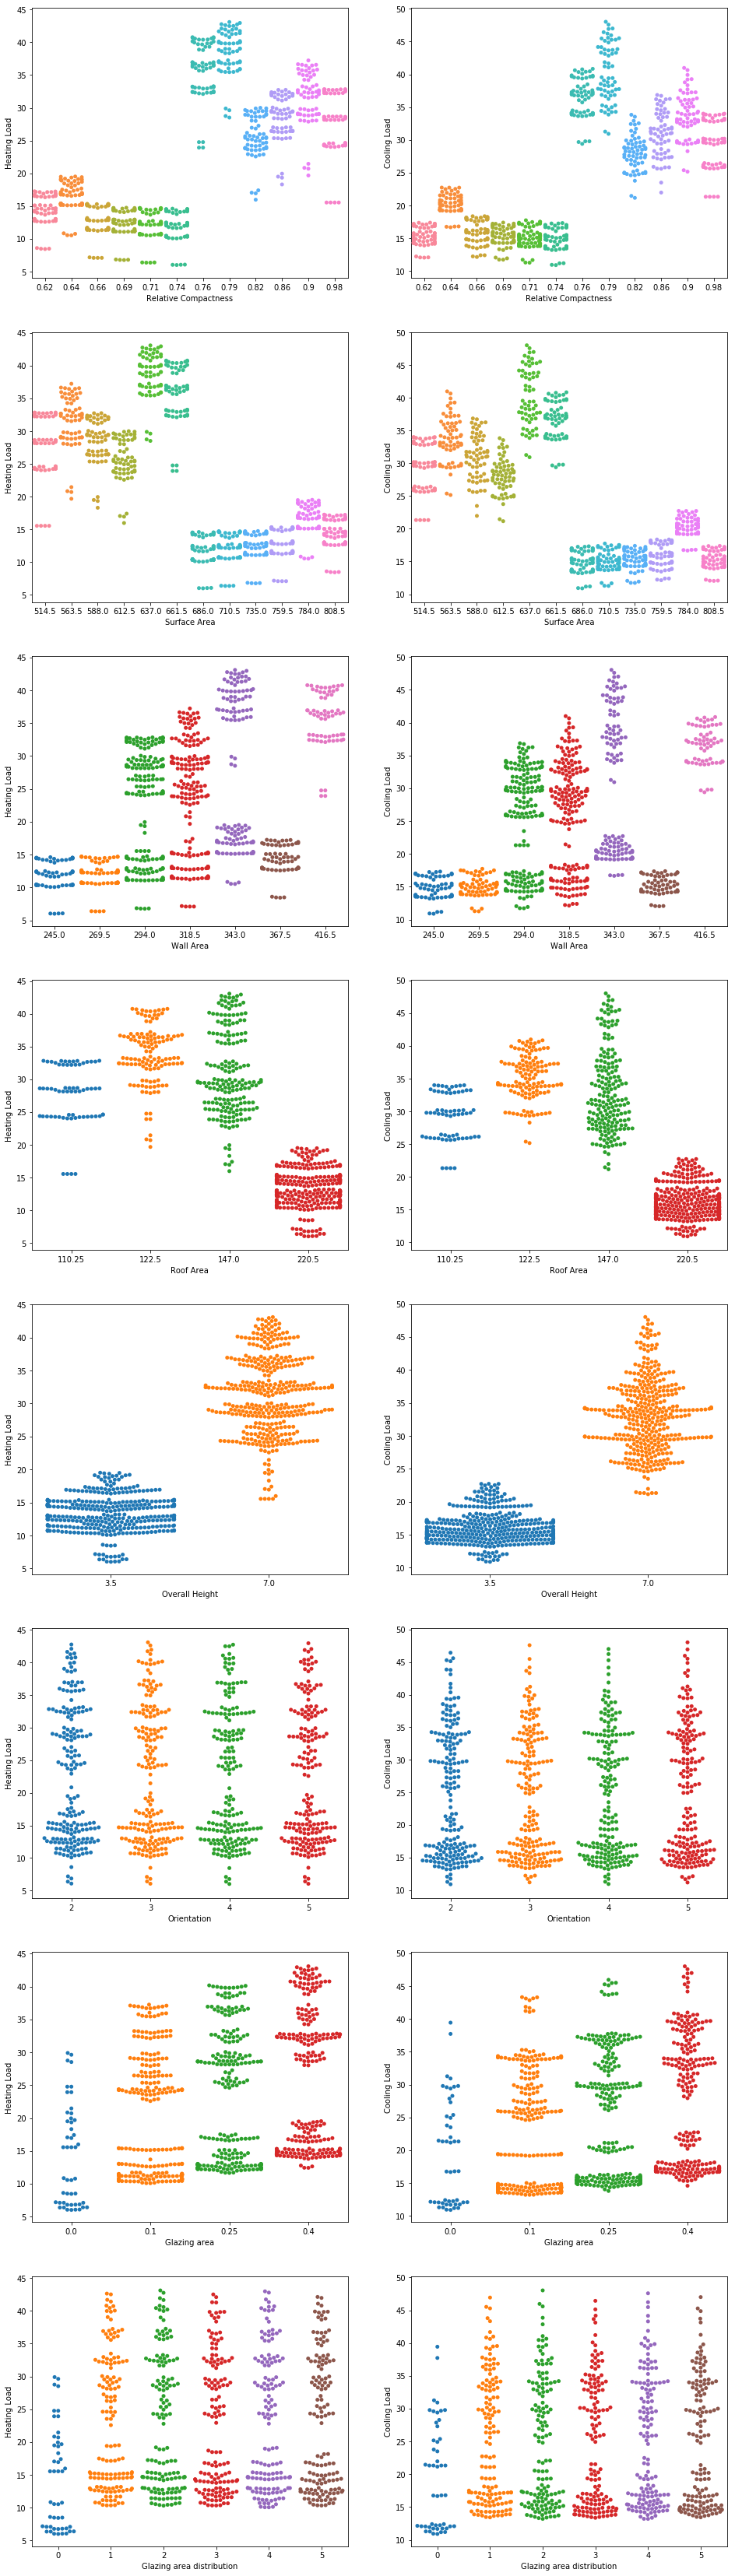

In [9]:
fig, ax = plt.subplots(nrows=len(feature_cols_basic), ncols=2, figsize=(16, 60))
# Loop through all the basic feature columns and plot each variable vs Cooling Load and Heating Load
for i, col in enumerate(feature_cols_basic):
    sns.catplot(x=col, y="Heating Load", kind="swarm", data=df, ax=ax[i][0])
    sns.catplot(x=col, y="Cooling Load", kind="swarm", data=df, ax=ax[i][1])
    plt.close(2)
    plt.close(3)


## Visualisations -  Spearman Correlation Coefficient Heat Map

Code source : https://stackoverflow.com/questions/51790062/heatmap-plot-of-a-pandas-dataframe-typeerror

Because the variables have a non-linear relationship, I decided to measure the correlation using Spearman  Correlation Coefficient to obtain a statistical metric regarding the association strength of each input variable with all of the other variables. The Spearman rank correlation coefficient can characterize general monotonic relationships and lies in the range [-1 1], where negative sign indicates inversely proportional and positive sign indicates proportional relationship, whilst the magnitude denotes how strong this relationship is.[3] 

The first heat map ignores the p-values and just shows the Spearman correlation, however the second heat map only shows the values where the p-value is less than 0.05 thus indicating that the relation- ship is statistically significant.  


We can see that the provided dataset has near perfectly positive and negative attributes. For example "Relative Compactness" is highly correlated with "Surface Area". This means there is a  high chance that the performance of any models will be impacted by a problem called  "Multicollinearity" which is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. In this situation the coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data.[4] There are multiple ways to deal with this problem. The easiest way is to delete or eliminate one of the perfectly correlated features. Another way is to use a dimension reduction algorithm such as Principle Component Analysis (PCA). [5]

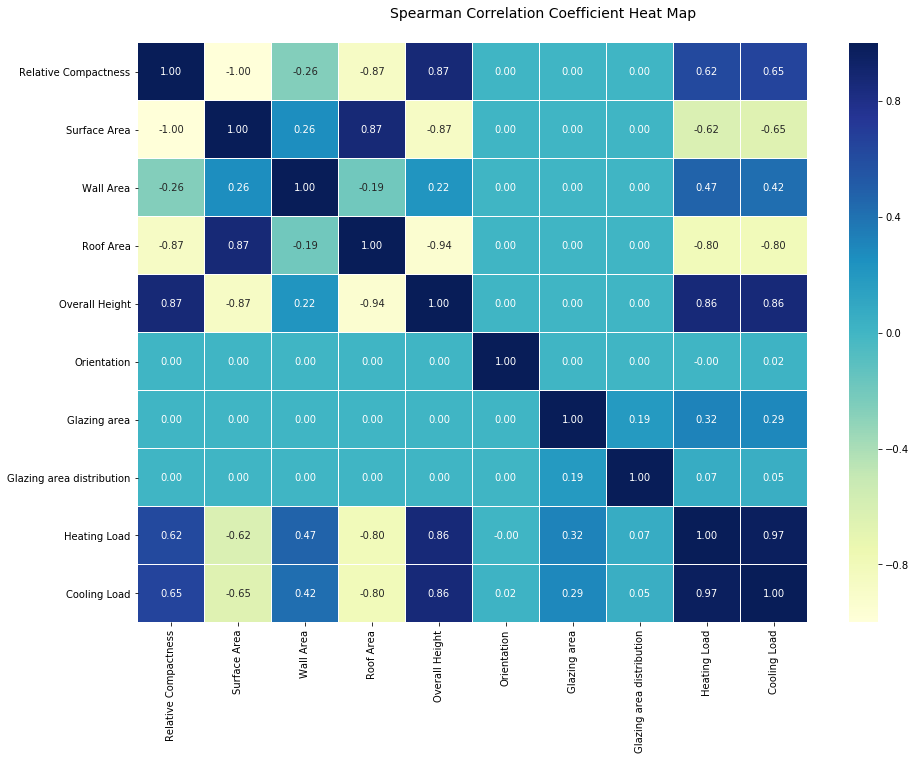

In [10]:
f, ax = plt.subplots(figsize=(15, 10))
# Create two new dataframes for both the spearmanr results and the p-values
coeffmat = pd.DataFrame(index=df.columns, columns=df.columns)
pvalmat = pd.DataFrame(index=df.columns, columns=df.columns)
# Loop through each value in the data set
for i in range(df.shape[1]):
    for j in range(df.shape[1]):
        # Crate two arrays containg the values of the current column and row
        x = np.array(df[df.columns[i]])
        y = np.array(df[df.columns[j]])
        # Caluate the Spearman Correlation Coefficient and p value for the given row and column
        corrtest = spearmanr(x, y)
        coeffmat.iloc[i, j] = corrtest[0]
        pvalmat.iloc[i, j] = corrtest[1]

# Convert all the values to numeric values 
coeffmat = coeffmat.apply(pd.to_numeric, errors='ignore')
pvalmat = pvalmat.apply(pd.to_numeric, errors='ignore')
# Create the heat map with the Spearman Correlation Coefficients
hm = sns.heatmap(round(coeffmat, 2), annot=True,
                 ax=ax, fmt='.2f', cmap="YlGnBu", linewidths=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('Spearman Correlation Coefficient Heat Map', fontsize=14)



As you can see when the Spearman Correlation Coefficient with a p-value less than 0.05 are removed you can still see that for example "Relative Compactness" is highly correlated with "Surface Area", which means by using these features may lead to miss leading results and therefore should be removed. 


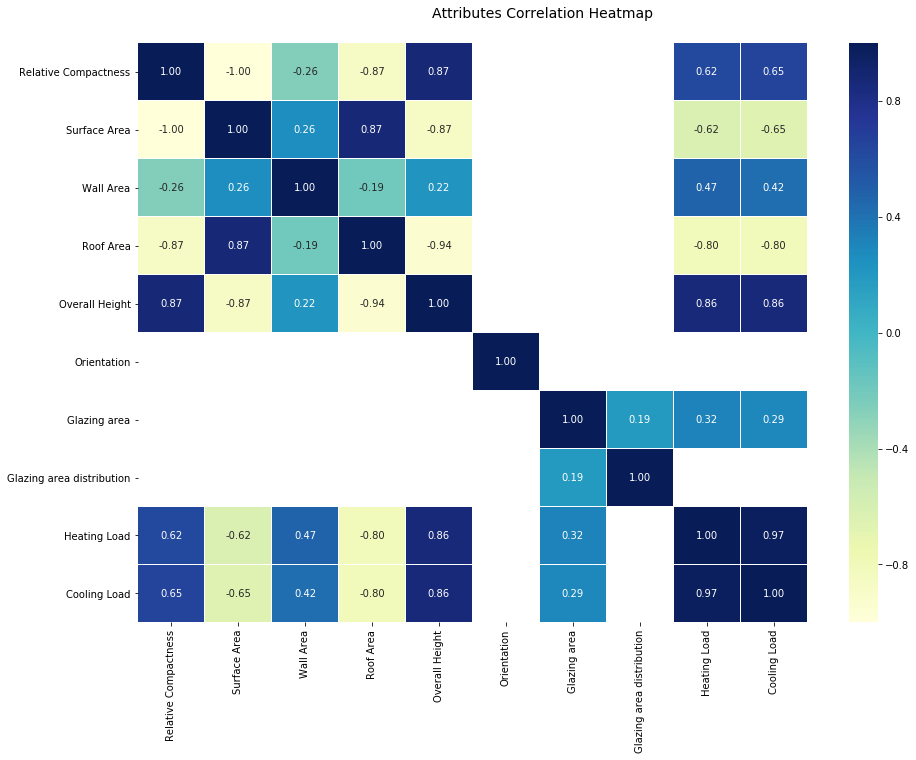

In [11]:
f, ax = plt.subplots(figsize=(15, 10))
# Create a mask where the values in the pvalmat data frame are greater than 0.05
mask = np.zeros_like(coeffmat, dtype=np.bool)
mask[(pvalmat >= 0.05)] = True
# Display the new heat map with only values that had a p-value less than 0.05
hm1 = sns.heatmap(round(coeffmat, 2), mask=mask, annot=True,
                  ax=ax, fmt='.2f', cmap="YlGnBu", linewidths=.05)
f.subplots_adjust(top=0.93)
t1 = f.suptitle('Attributes Correlation Heatmap', fontsize=14)


### Visualisations - Parallel Coordinates


The final visualisation I decided to create was using parallel coordinates. In order to create this visualisation I first had to convert the continuous outputs "Heating Load" and "Cooling Load" to a discrete domain. In order to do this I calculated the lower and upper quartiles and then classified all values less than the lower quartile as "low", all values in-between the upper and lower quartile as "medium" and all values greater than the upper quartile as "high". In addition I also had to scale the features into values between -2 to 2. 

There is one visualisation for each of the output variables and in each visualisation the data points are represented as connected line segments. The vertical lines then corresponds to a feature, thus a complete line across all the vertical lines corresponds to a single row in the original csv file. From the graphs we can make observations such as, when the "Heating Load" is higher, it tends to be the case that the wall area is greater. 

In [12]:
# Find the quartiles
q1_heating, q3_heating = np.percentile(df['Heating Load'], [25, 75])
q1_cooling, q3_cooling = np.percentile(df['Cooling Load'], [25, 75])

# Create a new dataframe with the output variables as discrete
df_copy = df.copy()
df_copy['Heating Load'] = df_copy['Heating Load'].apply(
    lambda value: 'low' if value <= q1_heating
    else 'medium' if value <= q3_heating
    else 'high')
df_copy['Cooling Load'] = df_copy['Cooling Load'].apply(
    lambda value: 'low' if value <= q1_cooling
    else 'medium' if value <= q3_cooling
    else 'high')
df_copy.reset_index(inplace=True, drop=True)
subset_df = df_copy[feature_cols_basic]
# Scale the data 
scaled_df = ss.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled_df, columns=feature_cols_basic)


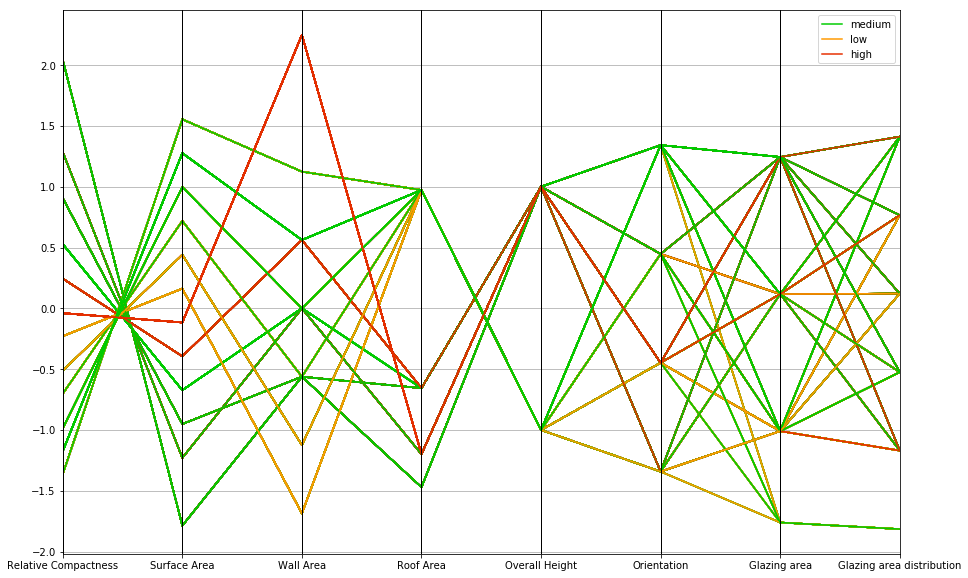

In [13]:
final_df = pd.concat([scaled_df, df_copy['Heating Load']], axis=1)
final_df.reset_index(inplace=True, drop=True)
# Plot the parallel coordinates
f, ax = plt.subplots(figsize=(15, 10))
pc = parallel_coordinates(final_df, 'Heating Load', color=('#00cc00', '#ff9900', '#e62e00'), ax=ax)


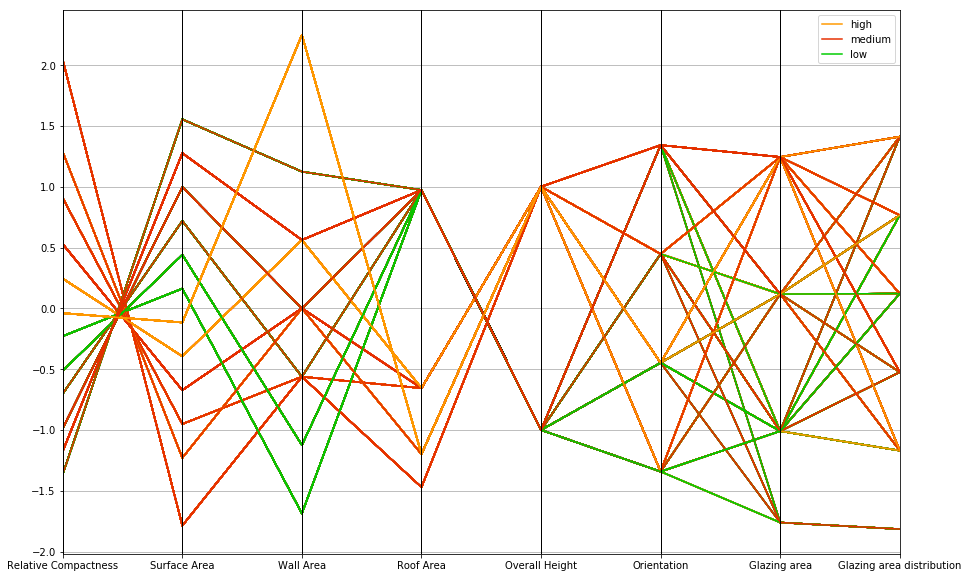

In [14]:
final_df = pd.concat([scaled_df, df_copy['Cooling Load']], axis=1)
final_df.reset_index(inplace=True, drop=True)

f, ax = plt.subplots(figsize=(15, 10))
pc = parallel_coordinates(final_df, 'Cooling Load', color=('#ff9900', '#e62e00', '#00cc00'), ax=ax)


# Section 3 - Choosing a suitable subset of features


## Feature Selection - Random Forests

code Source : https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

As I discussed earlier because there are features that are highly correlated, there is a  high chance that the performance of any regression models will be impacted by a problem called  "Multicollinearity". However decision trees and boosted trees algorithms are immune to multicollinearity by nature. When they decide to split, the tree will choose only one of the perfectly correlated features.[4] I therefore decided to decided to implement random forests to rank the features. Bellow is my implementation which ranks each features importance with respect to y1 and y2. 

Because Random Forests use tree-based strategies they will naturally rank features by how well they improve the purity of the node. This means a decrease in the gini impurity over all the trees. Thus nodes with the greatest impurity happen at the start of the trees, while notes with the least decrease in impurity occur at the end of trees.[6]. After a tree has been created, one can check the importance of a feature by looking at the difference in Gini impurity when the feature is used compared to the case when the feature is not used. 

In order to implement the Random Forest model I used the RandomForestClassifier object from Sklearn. However to before this would work I had to again convert the output features from a continuous domain to a discrete domain. This time I used the KBinsDiscretizer object from Sklearn which converts the outputs of each of the target variables into bins, where there are 10 bins. This has the effect of converting the problem from a regression problem to a classification problem. Finally I used cross-validation to protect against overfitting, this was particularly necessary because the data set only contained 768 samples. 

As we can see here the most important features are Glazing Area, Glazing area distribution, which match the findings presented in the paper. What is interesting here is that Orientation is ranked much better for predicting Y2 than it is for predicting Y1. This therefore might suggest that it worth building two models, one for predicting Y1 and one predicting Y2, where Orientation is only used in the later model. 

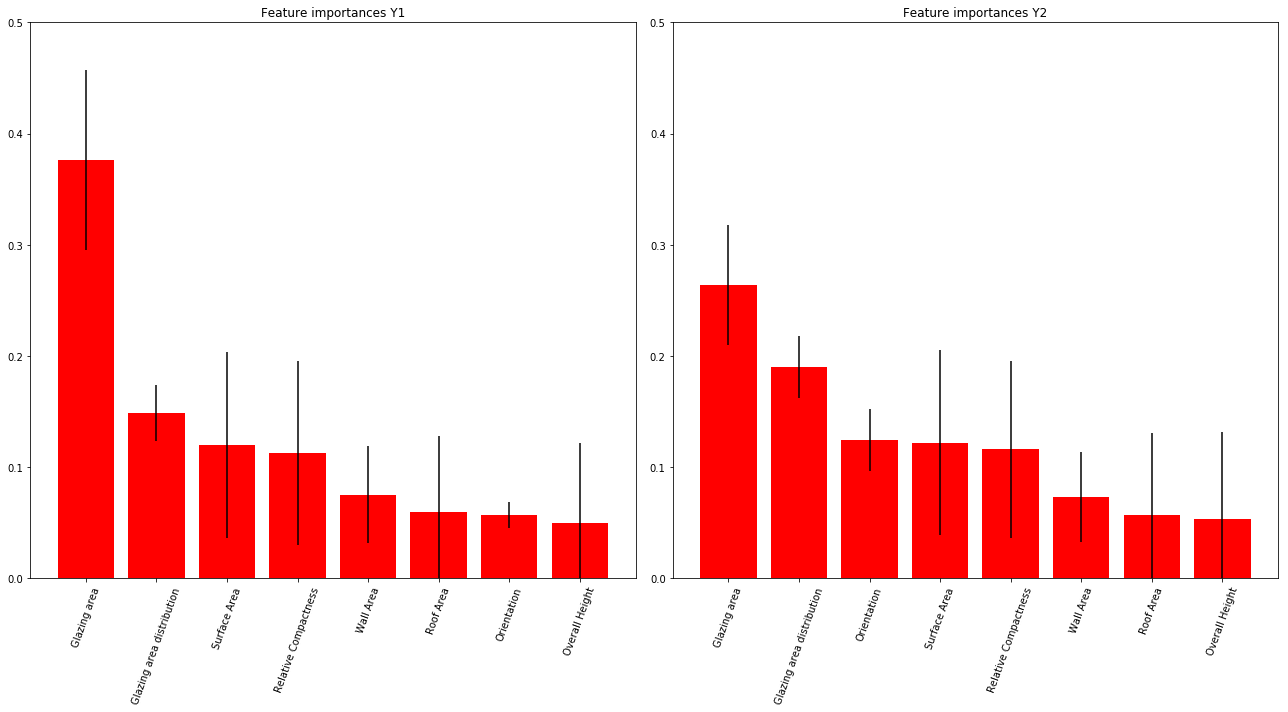

In [15]:
fig = plt.figure(figsize=(18, 10))

X = df[feature_cols_basic]
col_names = dict(zip([0, 1, 2, 3, 4, 5, 6, 7], feature_cols_basic))
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# Create the random forests
y_binned, forests, importances, std, indices = [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]
for i in range(2):
    y_binned[i] = est.fit_transform(df[target_cols[i]].values[:, np.newaxis])
    forests[i] = RandomForestClassifier(n_estimators=250, random_state=1)
    forests[i].fit(X, y_binned[i])
    cross_val_score(forests[i], X, y_binned[i], cv=100)
    importances[i] = forests[i].feature_importances_
    std[i] = np.std([tree.feature_importances_
                     for tree in forests[i].estimators_], axis=0)
    indices[i] = np.argsort(importances[i])[::-1]

# Save the results in a data frame 
results = pd.DataFrame({'Importance Y1': forests[0].feature_importances_,
                        'Importance Y2': forests[1].feature_importances_},
                       index=X[feature_cols_basic].columns,
                       columns=['Importance Y1', 'Importance Y2'])

# Plot the results
ax1 = fig.add_subplot(121)
plt.title("Feature importances Y1")
ax1.set_ylim(0, 0.5)
ax1.bar(range(X.shape[1]), importances[0][indices[0]],
        color="r", yerr=std[0][indices[0]])
plt.xticks(range(X.shape[1]),
           [list(col_names.values())[i] for i in indices[0]],
           rotation=70)

ax2 = fig.add_subplot(122)
plt.title("Feature importances Y2")
ax2.set_ylim(0, 0.5)
ax2.bar(range(X.shape[1]), importances[1][indices[1]],
        color="r", yerr=std[1][indices[1]])
plt.xticks(range(X.shape[1]),
           [list(col_names.values())[i] for i in indices[1]],
           rotation=70)
plt.tight_layout()


In [16]:
display(results)

,Importance Y1,Importance Y2
Relative Compactness,0.112604,0.116147
Surface Area,0.119716,0.122013
Wall Area,0.075450,0.073076
Roof Area,0.059740,0.057239
Overall Height,0.050165,0.053441
Orientation,0.057028,0.124314
Glazing area,0.376222,0.263828
Glazing area distribution,0.149073,0.189943


## Extension 1 - Synthetic Features 

After completing the "Machine Learning Crash Course" by Google, I discovered that one can create new features called synthetic features which are a combination of other features. I therefore though that this could prove use full in the context of this practical. 

Because the paper provided provides us with the U-Values of the building materials used and the ventilation rate, I  thought this could be used to create a new feature. After some research I discovered I could roughly calculate the total heat loss of a building using such values. It should be noted that this is an approximation as all the required values need to calculate this are not provided, i.e. volume of building, but they can be approximated. 

In order to make this feature I used the information provided in https://www.open.edu/openlearn/nature-environment/the-environment/energy-buildings/content-section-2.4.1. I also used a value for the Coldest Month Heating DB as 1.6 for Athens Greece, which was found using the ashrae climatic design conditions 2017 (http://ashrae-meteo.info). I also made the assumption that an internal temperature of 20°C is maintained, which seemed reasonable considering the thermostat temperature range was stated as (19°C - 24°C) moreover other researchers used this value. 


The first value I needed to calculate was the total fabric heat loss flow rate, Qf = (Σ U × A x) × ΔT which is the sum of all the U-values of the individual external elements i.e. walls, roof, floor, windows multiplied by their respective areas multiplied by the inside - outside temperature difference, ΔT. [7] 

The next value I needed to calculate was the ventilation heat loss, Qv = 0.33 × n × V × ΔT watts. where n is the number of air changes per hour (ACH) which was stated as "0.5 for air change rate " and V is the volume of the house (m^3) which in the paper is stated as 771.75 m ^ 3. [7] 

Summing the fabric and ventilation contributions gives a total whole-house heat loss coefficient calculation of (Qf + Qv)/ΔT. [7] 


Thus to make this synthetic feature I had to work out both the surface area of the floor and of the windows. Because in the paper it states "Taking the elementary cube (3.5 × 3.5 × 3.5) we generated 12 building forms where each building form is composed of 18 elements (elementary cubes)." We now that the width of each cube is 3.5, thus the floor area is 18 * (3.5 ^ 2) = 220.5. Next because we know that the glazing area is represented as a percentage of the floor area, all we need to do is multiply the value for the glazing area by 220.5. 

As you can see I have also calculated the Spearman Correlation Coefficient with a p-value for the new feature in relation to all the other variables and in all cases the correlation is less 0.9 suggesting that it will not suffer from multicollinearity. 

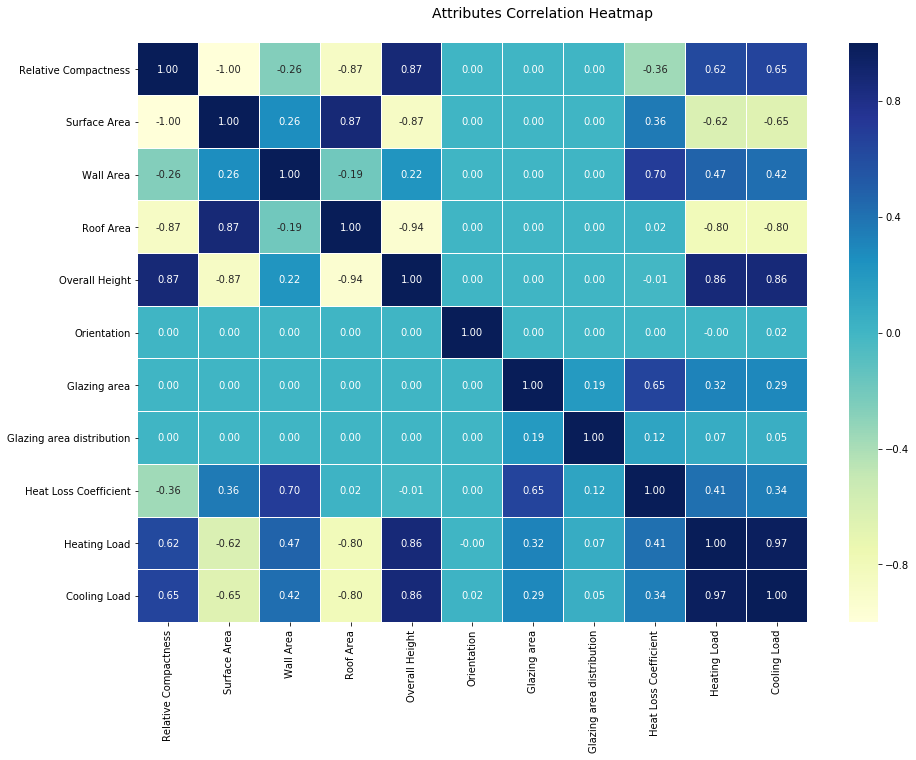

In [17]:
fabric_heat_loss = np.sum(((1.780 * df['Wall Area'].values),
                           (2.260 * (220.5 * df['Glazing area'].values)),
                           (0.860 * (np.repeat(220.5, len(df.index)))),
                           (0.500 * df['Roof Area'].values)), axis=0, dtype=np.float)

ventilation_heat_loss = (20 - 1.6) * np.repeat((0.33 * 0.5 * 771.75), len(df.index))

df['Heat Loss Coefficient'] = fabric_heat_loss + ventilation_heat_loss

feature_cols_extended = feature_cols_basic + ['Heat Loss Coefficient']

f, ax = plt.subplots(figsize=(15, 10))
hm1 = sns.heatmap(round(df[feature_cols_extended + target_cols].corr('spearman'), 2),
                  annot=True, ax=ax, fmt='.2f', cmap="YlGnBu", linewidths=.05)
f.subplots_adjust(top=0.93)
t1 = f.suptitle('Attributes Correlation Heatmap', fontsize=14)


### Synthetic Feature Ranking

After creating the synthetic feature I re-ran the random forest feature ranking to see how well my new feature was doing. As it can be seen it is the most important feature for predicting Y1 and the second most important feature for predicting Y2 this coupled with the fact that it that it is not highly correlated with any of the other features suggests that it is a good feature. Moreover an interesting observation is that now Glazing area has been ranked lower which is due to the fact that now there are more features and the sum of all the importance rating will always equal 1, which suggests that by adding new relevant features other features feature importances will be reduced. 

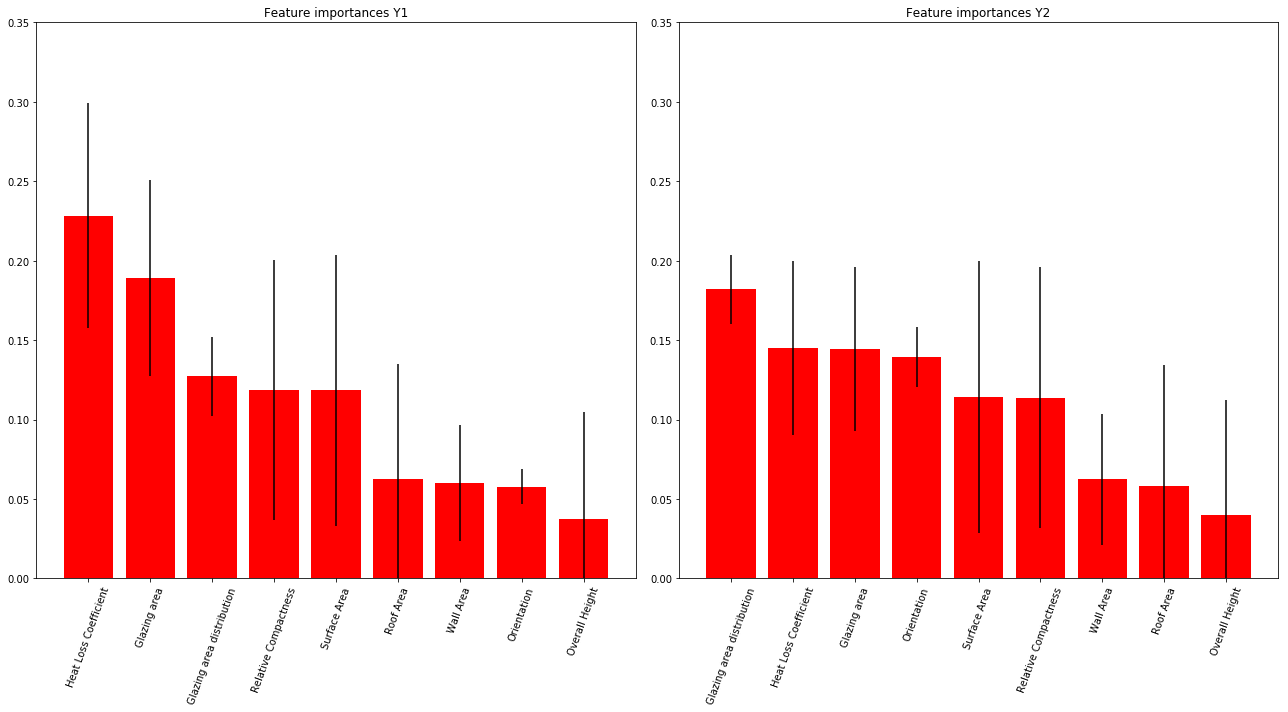

In [18]:
fig = plt.figure(figsize=(18, 10))

X = df[feature_cols_extended]
col_names = dict(zip([0, 1, 2, 3, 4, 5, 6, 7, 8], feature_cols_extended))
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# Create the random forests
y_binned, forests, importances, std, indices = [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]

for i in range(2):
    y_binned[i] = est.fit_transform(df[target_cols[i]].values[:, np.newaxis])
    forests[i] = RandomForestClassifier(n_estimators=250, random_state=1)
    forests[i].fit(X, y_binned[i])
    cross_val_score(forests[i], X, y_binned[i], cv=100)
    importances[i] = forests[i].feature_importances_
    std[i] = np.std([tree.feature_importances_
                     for tree in forests[i].estimators_], axis=0)
    indices[i] = np.argsort(importances[i])[::-1]

# Save the results in a data frame 
results = pd.DataFrame({'Importance Y1': forests[0].feature_importances_,
                        'Importance Y2': forests[1].feature_importances_},
                       index=X[feature_cols_extended].columns,
                       columns=['Importance Y1', 'Importance Y2'])

# Plot the results
ax1 = fig.add_subplot(121)
plt.title("Feature importances Y1")
ax1.set_ylim(0, 0.35)
ax1.bar(range(X.shape[1]), importances[0][indices[0]],
        color="r", yerr=std[0][indices[0]])
plt.xticks(range(X.shape[1]),
           [list(col_names.values())[i] for i in indices[0]],
           rotation=70)

ax2 = fig.add_subplot(122)
plt.title("Feature importances Y2")
ax2.set_ylim(0, 0.35)
ax2.bar(range(X.shape[1]), importances[1][indices[1]],
        color="r", yerr=std[1][indices[1]])
plt.xticks(range(X.shape[1]),
           [list(col_names.values())[i] for i in indices[1]],
           rotation=70)
plt.tight_layout()


In [19]:
display(results)

,Importance Y1,Importance Y2
Relative Compactness,0.118574,0.113868
Surface Area,0.118449,0.114303
Wall Area,0.060185,0.062325
Roof Area,0.062464,0.058367
Overall Height,0.037682,0.040230
Orientation,0.057798,0.139488
Glazing area,0.189122,0.144409
Glazing area distribution,0.127317,0.181925
Heat Loss Coefficient,0.228410,0.145085


## Section 4 - Training a Regression Model 

### Regression Model - All Initial Features

The first model I decided to create was a simple Linear Regression model, using the LinearRegression module from Sklearn. I decided for my first model to include all the initial features and use this as a bench mark to beat. Therefore I removed the new synthetic feature mentioned above.

Because I am using Ordinary least squares which is invariant, there is no real need for standardization. As can be seen the results I obtained are similar to those obtained in the paper (IRLS) despite not using cross-validation. Moreover although the Mean Absolute Error I achieved is is slightly higher for both y1 and y2, the Mean Squared Error I get for y2 is better than the Mean Squared Error listed in the paper. 

Finally I opted to use Repeated Kfold's where I set k to 10, and the number of repetitions was set to 100. This has the effect of splitting the data set into 10 different subsets. On each fold one of the subsets is left out and used as the test set and the remaining 9 subsets are used for training. This is then repeated 100 times. I  then average the accuracy achieved attained in each of the folds to retrieve the overall accuracy. The advantage of using KFold is that the resulting model genrally results in a less bias and a less optimistic estimate of the model skill over is attained vs other methods, such as a simple train/test split.



In [20]:
from sklearn.model_selection import RepeatedKFold

X = df[feature_cols_basic].values
y = df[target_cols].values

reg = LinearRegression(fit_intercept=True)

acc = [0] * 1000
mse1, mse2 = [0] * 1000, [0] * 1000
mae1, mae2 = [0] * 1000, [0] * 1000

kf = RepeatedKFold(n_splits=10, n_repeats=100, random_state=0)
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg.fit(X_train, y_train)
    acc[i] = reg.score(X_test, y_test)
    y_pred = reg.predict(X_test)
    mse1[i] = mean_squared_error(y_test[:, 0], y_pred[:, 0])
    mse2[i] = mean_squared_error(y_test[:, 1], y_pred[:, 1])
    mae1[i] = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
    mae2[i] = mean_absolute_error(y_test[:, 1], y_pred[:, 1])

print('Y1 MSE: ' + str(sum(mse1) / 1000))
print('Y2 MSE: ' + str(sum(mse2) / 1000))
print('Y1 MAE: ' + str(sum(mae1) / 1000))
print('Y2 MAE: ' + str(sum(mae2) / 1000))
print('Final accuracy: ' + str(sum(acc) / 1000))


Y1 MSE: 8.708703183754611
Y2 MSE: 10.3606978184662
Y1 MAE: 2.0886466293830135
Y2 MAE: 2.2711246342157043
Final accuracy: 0.899259694640555


### Regression Model - Subset Features

After building the initial model with all the features, I decided to pick a subset of features. In order to pick the features I decided to remove all features which ranked poorly in the Random Forest feature selection and that also had a high correlation with other variables. For example "Relative Compactness" was highly correlated with "Surface Area" and because "Surface Area" was ranked better than "Relative Compactness" I decided to remove "Relative Compactness". Again because "Roof Area" and "Overall Height" were highly correlated, I decided to drop the feature "Overall Height" as it ranked lower. 

By choosing a subset of variables to train on not only will I avoid the perils surrounding multicollinearity, speed up training and reduce noise in the dataset. After removing said features I re-ran the LinearRegression module, this time the model slightly worse and only achieved an average accuracy of 83, which is lower than the accuracy achieved in the previous model.  



In [21]:
X = df[[
    'Surface Area',
    'Wall Area',
    'Roof Area',
    'Orientation',
    'Glazing area',
    'Glazing area distribution',
    'Heat Loss Coefficient'
]].values

y = df[target_cols].values
reg = LinearRegression(fit_intercept=True)

acc = [0] * 1000
mse1, mse2 = [0] * 1000, [0] * 1000
mae1, mae2 = [0] * 1000, [0] * 1000

kf = RepeatedKFold(n_splits=10, n_repeats=100, random_state=0)
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg.fit(X_train, y_train)
    acc[i] = reg.score(X_test, y_test)
    y_pred = reg.predict(X_test)
    mse1[i] = mean_squared_error(y_test[:, 0], y_pred[:, 0])
    mse2[i] = mean_squared_error(y_test[:, 1], y_pred[:, 1])
    mae1[i] = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
    mae2[i] = mean_absolute_error(y_test[:, 1], y_pred[:, 1])

print('Y1 MSE: ' + str(sum(mse1) / 1000))
print('Y2 MSE: ' + str(sum(mse2) / 1000))
print('Y1 MAE: ' + str(sum(mae1) / 1000))
print('Y2 MAE: ' + str(sum(mae2) / 1000))
print('Final accuracy: ' + str(sum(acc) / 1000))


Y1 MSE: 14.267720533642528
Y2 MSE: 16.46611968915122
Y1 MAE: 2.60446086073439
Y2 MAE: 2.802288370144169
Final accuracy: 0.8383900464429337


## Section 5 - Comparison with other models

### Random Forest Regressor

Code Source : https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html

The next model I decided to implement was a Random Forest Regressor model. The reason I chose this model is because in the paper provided they too use Random Forests and are able to demonstrate a higher accuracy is achieved over linear regression. One key difference here is that I have opted not to convert the initial problem into a classification problem at this point. In addition to this I also multi-output meta estimator which fits one regressor per target [8]. The reason I decided to this on top of the regular Random Forest Regressor model is because the random forest regressor will only ever predict values within the range of observations or closer to zero. As a result the predictions are always biased toward the bottom left corner of the bellow graph. 

By using a multi-output meta estimator as well was a Random Forest Regressor I  and build a model which can extrapolate better. This seems to be overlooked in the paper as although their model may exhibit a high accuracy on the training set and even the test set, it still may not generalize well to new data. This could especially be problematic for any models trained on the provided dataset as the data set provided is generated by a program and considers a potentially minute subset of what data could be found when using real life data.

Again I have decided to use KFold as means of gaining a better idea of the models true performance. However this time I set the number of repetitions to 10 in order to keep the training time lower. 

Because the max_depth parameter is not provided to the model, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.[9]

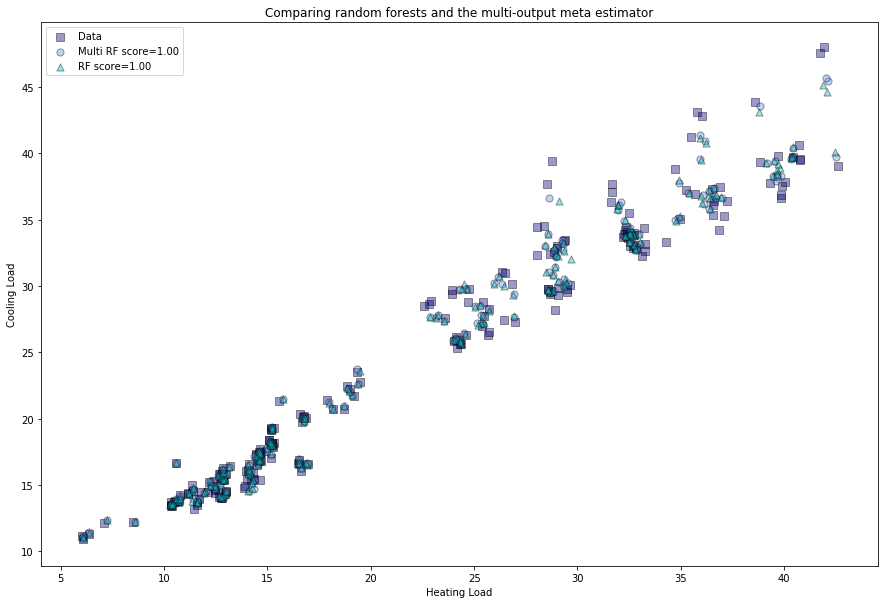

In [22]:
X = df[feature_cols_extended].values
y = df[target_cols].values

regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=250, random_state=0))
regr_rf = RandomForestRegressor(n_estimators=250, random_state=0)

acc = [0] * 100
mse1, mse2 = [0] * 100, [0] * 100
mae1, mae2 = [0] * 100, [0] * 100
kf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Fit the models
    regr_multirf.fit(X_train, y_train)
    regr_rf.fit(X_train, y_train)
    # Make the predictions
    y_pred_multirf = regr_multirf.predict(X_test)
    y_pred_rf = regr_rf.predict(X_test)
    # Save the results of each fold
    acc[i] = (regr_multirf.score(X_test, y_test),
              regr_rf.score(X_test, y_test))
    mse1[i] = ((mean_squared_error(y_test[:, 0], y_pred_multirf[:, 0])),
               mean_squared_error(y_test[:, 0], y_pred_rf[:, 0]))
    mse2[i] = ((mean_squared_error(y_test[:, 1], y_pred_multirf[:, 1])),
               mean_squared_error(y_test[:, 1], y_pred_rf[:, 1]))
    mae1[i] = ((mean_absolute_error(y_test[:, 0], y_pred_multirf[:, 0])),
               mean_absolute_error(y_test[:, 0], y_pred_rf[:, 0]))
    mae2[i] = ((mean_absolute_error(y_test[:, 1], y_pred_multirf[:, 1])),
               mean_absolute_error(y_test[:, 1], y_pred_rf[:, 1]))

# Create a new train test split to show how each model predicts vs the grond truth     
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=400, test_size=200, random_state=4)
y_multirf = regr_multirf.predict(X_test)
y_rf = regr_rf.predict(X_test)

f, ax = plt.subplots(figsize=(15, 10))

s = 50
a = 0.4
plt.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, y_test))
plt.scatter(y_rf[:, 0], y_rf[:, 1], edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(X_test, y_test))

plt.xlabel("Heating Load")
plt.ylabel("Cooling Load")
plt.title("Comparing random forests and the multi-output meta estimator")
plt.legend()
plt.show()


In [23]:
print('MultiOutputRegressor  Y1 MSE: ' + str(sum([x[0] for x in mse1]) / 100))
print('MultiOutputRegressor  Y2 MSE: ' + str(sum([x[0] for x in mse2]) / 100))
print('MultiOutputRegressor  Y1 MAE: ' + str(sum([x[0] for x in mae1]) / 100))
print('MultiOutputRegressor  Y2 MAE: ' + str(sum([x[0] for x in mae2]) / 100))
print('\nRandomForestRegressor Y1 MSE: ' + str(sum([x[1] for x in mse1]) / 100))
print('RandomForestRegressor Y2 MSE: ' + str(sum([x[1] for x in mse2]) / 100))
print('RandomForestRegressor Y1 MAE: ' + str(sum([x[1] for x in mae1]) / 100))
print('RandomForestRegressor Y2 MAE: ' + str(sum([x[1] for x in mae2]) / 100))

print('\nMultiOutputRegressor Final accuracy: ' + str(sum([x[0] for x in acc]) / 100))
print('RandomForestRegressor Final accuracy: ' + str(sum([x[1] for x in acc]) / 100))


MultiOutputRegressor  Y1 MSE: 0.21362646858508846
MultiOutputRegressor  Y2 MSE: 2.5522768265169655
MultiOutputRegressor  Y1 MAE: 0.3110671831168837
MultiOutputRegressor  Y2 MAE: 0.9762033543403963

RandomForestRegressor Y1 MSE: 0.21712312419716814
RandomForestRegressor Y2 MSE: 3.2481030012460805
RandomForestRegressor Y1 MAE: 0.30854366172248837
RandomForestRegressor Y2 MAE: 1.0565681848256998

MultiOutputRegressor Final accuracy: 0.9846018490227199
RandomForestRegressor Final accuracy: 0.9817175354603589


### Results

Here we can see that the Random Forest and the multi-output meta estimator both preformed much better than the linear models previously trained. This suggests that the original data is not linear and therefore the Linear Regression model cannot find the correct coefficients to model the data correctly. What is interesting is that by training two Random Forest models on both output variables vs training one model on both out variables together only has a very minute effect on the overall accuracy. As previously mentioned this approach might not extrapolate as well as the linear model, however I have tried to provide an implementation which can extrapolate to some extent. 

It should be noted that although the models provided here achieve better accuracy's than the linear models, their training time was far longer. Moreover they have become a much more complex to interpret, when compared to the simple coefficients learned by the linear model.  However they have I am still very pleased with their results which are better than those lusted in the paper. Moreover the  accuracy achieved by the MultiOutputRegressor is better than those achieved by the RandomForestRegressor, where the average Mean Squared Error is over .5 lower. 

### Gradient Boosting Regressor

Code Source : https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py

The next model I decided to investigate was a Gradient Boosting Machine, the reason I chose to investigate this model is because they are comparable to Random Forest as both are ensemble learning methods which make predictions by combining the outputs from individual tree. However both models differ in the the trees are ordered and in the way the results are combined. Moreover a Gradient Boosting Machine builds one tree at a time and each new tree is used to correct the errors made by previously trained tree. [9] 

Another reason I felt it would be interesting to investigate Gradient Boosting is because when building a Gradient Boosting machine one can again observe the importance of the input features. Therefore making an interesting comparison to the feature rankings obtained by the Random Forests. 

Because the Gradient Boosting Regressor dose not support multi target regression natively and because I wanted to observe the feature importance of each feature with respect to a single output variable I opted to create 2 Gradient Boosting Regressor models and trained them on each of the output variables separately. Again I used repeated K folds to be consistent. It should also be noted that regularization via shrinkage (learning_rate < 1.0) is applied. As well as stochastic gradient boosting (subsample < 1.0), in an attempt to produce more accurate models by reducing the variance via bagging.[10]  

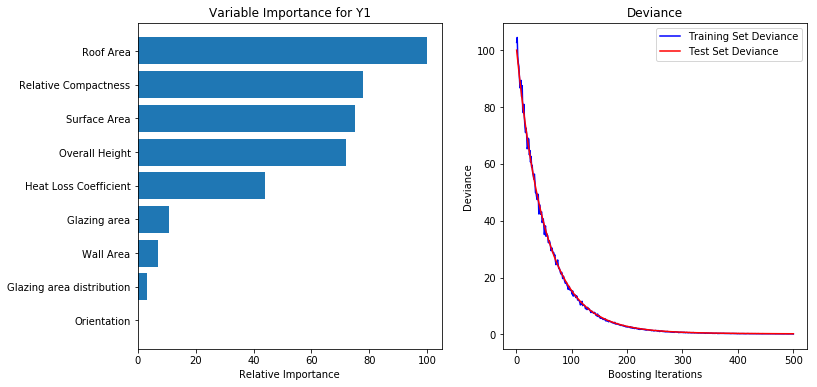

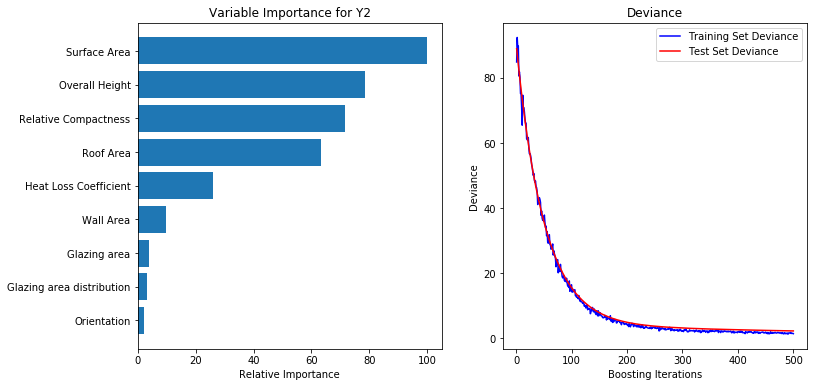

In [24]:
col_names = dict(zip([0, 1, 2, 3, 4, 5, 6, 7, 8], feature_cols_extended))
acc = [[], []]
mse = [[], []]
mae = [[], []]
X = df[feature_cols_extended].values
y = df[target_cols].values
for col in range(2):
    clf = ensemble.GradientBoostingRegressor(n_estimators=500,
                                             max_depth=4,
                                             min_samples_split=2,
                                             learning_rate=0.01,
                                             subsample=0.5,
                                             loss='ls')
    test_score = []
    kf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)
    for i, (train_index, test_index) in enumerate(kf.split(X, y[:, col])):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index, col], y[test_index, col]
        # Fit the model
        clf.fit(X_train, y_train)
        # Make the predictions
        y_pred = clf.predict(X_test)
        # Save the results of each fold    
        acc[col].append(clf.score(X_test, y_test))
        mse[col].append(mean_squared_error(y_test, y_pred))
        mae[col].append(mean_squared_error(y_test, y_pred))
        test_score.append(np.zeros((500), dtype=np.float64))
        for j, y_pred in enumerate(clf.staged_predict(X_test)):
            test_score[i][j] = clf.loss_(y_test, y_pred)
    # Compute the average test score
    test_score = np.average(test_score, axis=0)
    # Plot the deviance
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 2)
    plt.title('Deviance')
    plt.plot(np.arange(500) + 1, clf.train_score_, 'b-', label='Training Set Deviance')
    plt.plot(np.arange(500) + 1, test_score, 'r-', label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')
    # Plot the feature importance
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, df[feature_cols_extended].columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance for Y{0}'.format(col + 1))
    plt.show()


In [25]:
print('GradientBoostingRegressor  Y1 MSE: ' + str(sum([x for x in mse[0]]) / 100))
print('GradientBoostingRegressor  Y2 MSE: ' + str(sum([x for x in mse[1]]) / 100))
print('GradientBoostingRegressor  Y1 MAE: ' + str(sum([x for x in mae[0]]) / 100))
print('GradientBoostingRegressor  Y2 MAE: ' + str(sum([x for x in mae[1]]) / 100))
print('\nGradientBoostingRegressor Y1 Final accuracy: ' + str(sum([x for x in acc[0]]) / 100))
print('GradientBoostingRegressor Y2 Final accuracy: ' + str(sum([x for x in acc[1]]) / 100))


GradientBoostingRegressor  Y1 MSE: 0.2597934763722216
GradientBoostingRegressor  Y2 MSE: 2.3054536294810353
GradientBoostingRegressor  Y1 MAE: 0.2597934763722216
GradientBoostingRegressor  Y2 MAE: 2.3054536294810353

GradientBoostingRegressor Y1 Final accuracy: 0.9973888823775018
GradientBoostingRegressor Y2 Final accuracy: 0.9742760331399059


### Results 

As can be seen the Gradient Boosting Regressor model preformed incredibly well when predicting Y1 and achieved an accuracy of 0.99. However the Gradient Boosting Regressor model only achieved an accuracy of 0.97 thus the average of the two models can be assumed as 0.98 which is almost equal to the accuracy witnessed by the Random Forest models. What was interesting here was that the feature ranking where completely different from those obtained by the random forest implantation. 

### Neural Networks

Code Source : https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py

The final models I built where centered around the Multi-layer Perceptron classifier. The reason I chose to do this is because in the paper they talk about framing the problem as a multi-class classification problem. Further more, after completing the Classification section on Googles Machine Learning Crash Course, I got more exposure to Neural Network and how one can convert a regression problem into a classification problem. Although this section some what deviates away from the previous sections, I thought this would be a good opportunity to apply the knowledge I had learned. 

The first step I took was to scale the inputs in order to speed up the training, this was achieved by using the MinMaxScaler module provided in Sklearn. This module scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one. Next I had to convert the output from a continuous domain to a discrete domain, which I achieved the KBinsDiscretizer module. Because the range of values each of the output variables can take was approximately 35, I decided to use this as the number of bins to split the input data into. When training the model I opted to use StratifiedKFold which preserves a percentage of samples for each class, thus on each fold there will always samples belonging to all the classes.

In order to gain a better understanding of how hyper parameters can affect the over all performance of a model, I opted to use a wide range of different hyper parameters when training each model. However I kept a the number of hidden nodes in each layer constant, where the first layer had 250 hidden nodes, and the second hidden layer had 128 hidden nodes. Finally it should be noted that each of the models trained will stop once either the loss has converged or 1000 iterations have been competed. 

training: constant learning-rate
Training set score: 0.363636
Training set loss: 1.301515
training: constant with momentum
Training set score: 0.402597
Training set loss: 0.976304
training: constant with Nesterov's momentum
Training set score: 0.467532
Training set loss: 0.504420
training: inv-scaling learning-rate
Training set score: 0.038961
Training set loss: 3.525556
training: inv-scaling with momentum
Training set score: 0.207792
Training set loss: 2.464015
training: inv-scaling with Nesterov's momentum
Training set score: 0.194805
Training set loss: 2.474148
training: adam
Training set score: 0.506494
Training set loss: 0.641933


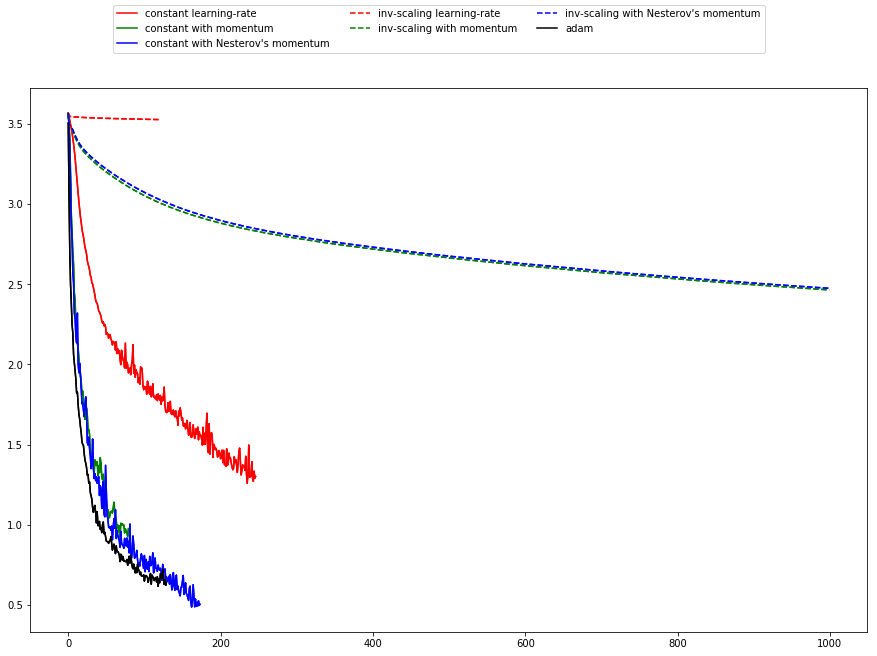

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))

# Initialise parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}
          ]

labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]

plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '--'},
             {'c': 'green', 'linestyle': '--'},
             {'c': 'blue', 'linestyle': '--'},
             {'c': 'black', 'linestyle': '-'}]

x = df[feature_cols_extended].values

# Scale the x features
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

# Covert Y into discrete data 
est = KBinsDiscretizer(n_bins=35, encode='ordinal', strategy='quantile')
y = est.fit_transform(df[target_cols[0]].values[:, np.newaxis])
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.1, random_state=1)

mlps = []
# Train each of the MLP Classifiers
for label, param in zip(labels, params):
    print("training: %s" % label)
    mlp = MLPClassifier((250, 128), verbose=0, random_state=0, max_iter=10, **param)
    # Using Stratified K Fold
    for train_split, val_split in StratifiedKFold(n_splits=10).split(np.zeros(len(X_train)), y_train):
        x_train_batch, y_train_batch = X_train[train_split], y_train[train_split]
        x_val, y_val = X_train[val_split], y_train[val_split]
        mlp.fit(x_train_batch, np.ravel(y_train_batch))
    mlps.append(mlp)
    print("Training set score: %f" % mlp.score(X_test, y_test))
    print("Training set loss: %f" % mlp.loss_)

for mlp, label, args in zip(mlps, labels, plot_args):
    ax.plot(mlp.loss_curve_, label=label, **args)

for mlp, label, args in zip(mlps, labels, plot_args):
    ax.plot(mlp.loss_curve_, label=label, **args)

fig.legend(ax.get_lines(), labels, ncol=3, loc="upper center")
plt.show()


### Results 

As can be seen, the results of the MLP classifier where significantly lower than those achieved by all the other models. This suggests that all of the models experienced high bias. This comes as little surprise; however as not only was the data set provided relatively small, there were also only nine features. The interesting takeaways from this were how the loss function decreases depending on the hyper parameters are chosen. As it can be seen when the learning rate was constant, the loss hardly decreased. Another interesting observation was when the learning-rate was inverted the time to convergence was a lot greater. Unsurprisingly when the optimizer was set to "Adam" the loss decreased the quickest as well as converging the fastest. 

## Section 6 - Discussion

## Conclusion 

In this project, I have covered a large number of different machine learning frameworks in order to try and predict both the Cooling Load and Heating Load, given the relative compactness, surface area, wall area, roof area, overall height, orientation, glazing area, glazing area distribution for a building. I was able to demonstrate an accuracy of 0.98 is achievable when using Multi-Output Regressor model in combination with a Random Forest Regressor to predict such values. This particularly compelling given that it exceeds the results reported in the paper provided. 

I have demonstrated that it was not necessary to discretize the output variables.
In addition, I have also explored various different methodologies found in the machine learning word such as building synthetic features and using cross-validation. And despite the fact that adding the synthetic feature when using linear regression (and also removing others) actually resulted in a decrease in accuracy my synthetic feature ranked when ranked with the Random Forest Classifier which suggests that it was still a worthwhile venture.

Finally, I have also been able to display that the use of Neural Networks in some cases may be superfluous and much simpler solution can be found as not only did the Neural Networks I trained perform poorly they also took considerably longer to train.  However, this was a good learning experience and also gave me an insight into how much hyper-parameters can affect the overall performance of a model. 


### References


[1] : https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

[2] : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html

[3] : Accurate quantitative estimation of energy performance of residential buildings using statistical machine learning tools

[4] : https://en.wikipedia.org/wiki/Multicollinearity

[5] : https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4

[6] : https://chrisalbon.com/machine_learning/trees_and_forests/feature_selection_using_random_forest/

[7] : https://www.open.edu/openlearn/nature-environment/the-environment/energy-buildings/content-section-2.4.1

[8] : https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html#sklearn.multioutput.MultiOutputRegressor

[9] :https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

[10] : https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regularization.html





